#ASSIGNMENT 4- Pip Benjamin
In this notebook we use GPU and CPU implementations of the forward and backward Euler methods, in order to model the time evolution of the heat equation.

We consider a square plate with sides $[-1, 1]\times [-1, 1]$, descretised into an $N\times N$ grid $u_{i,j} = u(x_i, y_j)$. The temperature of the plate evolves according to $u_t=\Delta u$, where the RHS can be discretised as: 
$$\Delta u_{i, j}\approx \frac{-4u_{i, j} + u_{i - 1, j} + u_{i + 1, j} + u_{i, j - 1} + u_{i, j+ 1}}{h^2}
$$
where $ h = \frac{2}{N-1}$.

Boundary conditions are implemented such that $u=5$ on one side and $u=0$ on the other sides. We introduce explicit and implicit methods for solving the PDE, in order to calculate the time taken for the temperature at the center of the plate to reach $u =1$, and examine how each method affects the accuracy of the result, compared to the known solution $t^* = 0.424011387033$, as well as the runtime.

Firstly, we import all neccesary modules, as well as defining a timer method, and methods for truncating floating points to a specified number of decimal places, and comparing two floats in order to determine up to how many decimal places they are equal.

In [1]:
import numpy as np
import numba
from numba import cuda
from matplotlib import pyplot as plt
import math
from scipy.sparse import coo_matrix, csr_matrix, eye, hstack
from scipy.sparse.linalg import spsolve, cg
import matplotlib.pyplot as plt

In [2]:
import time
class Timer:    
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

In [3]:
def truncate(number, digits) -> float:
    """Truncate a floating point number to a specified number of digits"""
    stepper = 10.0 ** digits
    return math.trunc(stepper * number) / stepper

#given solution
t_exp = 0.424011387033

figs = np.arange(1,14,1)
t_exp_digits = []
for digits in figs: #array of truncated solution values
  t_exp_digits.append(truncate(t_exp, digits))

def get_correct_figures(t):
  """return number of correct decimal places in calculated t compared to given solution"""
  t_digits = []
  for digits in figs:
    t_digits.append(truncate(t, digits)) #create array of t values truncated to consecutive numbers of decimal places
    if (t_digits[digits-1] != t_exp_digits[digits-1]): #compare to truncated solution value
      correct_digits = digits - 1 #if truncated calculation & solution are not equal, correct digits equal to point in array minus one
      break 
    else:
      correct_digits = 12
  return correct_digits

## Forward Euler- Explicit Time Stepping


 To start we implement the forward Euler method which utilises explicit time stepping. This method can be defined by: 
 $$\frac{U_{n+1} - U_n}{\Delta t} = f(U_n, t_n).$$
 
Here we use the recurrence relation $ U_{n+1} = (\boldsymbol{I}+\Delta t\boldsymbol{A})U_n$, where $U_n$ is a vector of length $N^2$ representing $u$ at time step $n$, $\boldsymbol{A}$ is an $N^2\times N^2$ matrix representing the Laplace operator $\Delta$, $\boldsymbol{I}$ is the $N^2\times N^2$ identity matrix and $\Delta t$ is the time step between iterations that we consider. For comparison, we demonstrate GPU and CPU implementations for iterations over this recurrence relation.

In the forward Euler method, it can be shown that $\Delta t\leq\frac{h^2}{4}$ in order to acheive a comvergent solution, so $\Delta t$ has been set accordingly in our method.

### GPU Implementation

In [4]:
TPB=32
@cuda.jit
def laplace_gpu_iterate(vec_in, vec_out, N_2):
  """Evaluate the discrete Laplace operator and perform one iteration of the forward Euler recurrence relation."""

  #shared array in which to load data associated with all points within thread block, 
  #as well as a layer of external values in order to calculate the five point stencil
  local_points = cuda.shared.array((34,34), numba.float32)
  
  #local thread pos
  ti=cuda.threadIdx.x
  tj=cuda.threadIdx.y

  #threadblock dimensions
  dim_i = cuda.blockDim.x
  dim_j = cuda.blockDim.y

  #global pos
  i, j = cuda.grid(2)

  if i >= N_2:
      return
  if j >= N_2:
      return

  #local points in shared memory (i.e the points we want to evaluate)
  li = ti+1
  lj = tj+1

  # Compute the vector index
  k = j * N_2 + i

  #assign points in shared array to corresponding point in input vector
  local_points[li,lj] = vec_in[k]
  
  #block bottom row
  if  tj==TPB-1:
    k_down = (j+1) * N_2 + i
    local_points[li,33] = vec_in[k_down]

  #block top row
  if tj == 0:
    k_up = (j-1) * N_2 + i
    local_points[li,0] = vec_in[k_up]

  #block left column
  if ti==0:
    k_left = j * N_2 + (i-1)
    local_points[0,lj] = vec_in[k_left]
  
  # block right column
  if ti == TPB-1:
    k_right = j * N_2 + (i+1)
    local_points[33,lj] = vec_in[k_right]
  
  #grid edge
  
  if j == N_2-1:
    local_points[li, lj+1] = numba.float32(0)
  if i == N_2-1:
    local_points[li+1, lj] = numba.float32(0)
  if j==0:
    local_points[li,lj-1] = numba.float32(0)
  if i==0:
    local_points[li-1, lj] = numba.float32(5)

  cuda.syncthreads()
  
  #EVALUATE POINTS
  up = local_points[li,lj-1]
  right = local_points[li+1, lj]
  down = local_points[li, lj+1]
  left = local_points[li-1, lj]
  center = local_points[li, lj]
  vec_out[k] = center -dt*(((N_2 +  1)/2)**2 * (numba.float32(4) * center - up - down - left - right))
  
  cuda.syncthreads()

# N_2=N-2
# nblocks = (N_2 +31) // 32
TPB=32

def time_iterate(N, dt):
  """Iterate over the GPU implentation of the forward Euler recurrence relation."""
  N_2=N-2

  its=np.int(3/dt)
  vec_in=np.zeros(N_2*N_2, dtype=np.float32)
  mid_point = (N_2//2)*N_2 + (N_2//2)
  t=0
  i=0
  for i in range(its):  
    N_2=N-2
    nblocks = (N_2 +31) // 32
    
    vec_out = np.zeros((N_2 * N_2), dtype=np.float32)
    laplace_gpu_iterate[(nblocks, nblocks), (TPB, TPB)](vec_in.astype('float32'), vec_out, N_2)
   
    t+=dt
    temp_mid = vec_out[mid_point]
    vec_in = vec_out
  
    if temp_mid>1:
      break
    i+=1

  return vec_in, t

###CPU Implementation

In [5]:
 def discretise_poisson(N):
    """Generate the matrix and rhs associated with the discrete Poisson operator."""
    
    nelements = 5 * N**2 - 16 * N + 16
    
    row_ind = np.empty(nelements, dtype=np.float32)
    col_ind = np.empty(nelements, dtype=np.float32)
    data = np.empty(nelements, dtype=np.float32)

    count = 0
    for j in range(N):
        for i in range(N):
            if i==0 or i == N - 1 or j == 0 or j == N - 1:
                row_ind[count] = col_ind[count] = j * N + i
                data[count] =  1
                count += 1
            else:
                row_ind[count : count + 5] = j * N + i
                col_ind[count] = j * N + i
                col_ind[count + 1] = j * N + i + 1
                col_ind[count + 2] = j * N + i - 1
                col_ind[count + 3] = (j + 1) * N + i
                col_ind[count + 4] = (j - 1) * N + i
                                
                data[count] = - 4 * ((N - 1)/2)**2
                data[count + 1 : count + 5] =  ((N - 1)/2)**2
                count += 5  

    return coo_matrix((data, (row_ind, col_ind)), shape=(N**2, N**2)).tocsr()

def sparse_explicit_iterate(N, dt):
  """Iterate over the forward Euler method for given array size N and time-step dt"""
  its=np.int(1/dt)
  A = discretise_poisson(N)
  L = eye(N**2,N**2) + dt* A
  mid_point = np.int((N//2)*N + N//2)
  x=np.zeros(N*N, dtype=np.float32)
  x[::N] = 5

  t=0
  i=0
  for i in range(its):
    x_n = L @ x
    
    #boundary condition
    x_n[::N] = 5

    temp_mid = x_n[mid_point]
    t+=dt 

    if temp_mid>1:
      break
    x=x_n
    i+=1
  return x, t

## Results

Below we see that the GPU and CPU implementations for N = 51 both return 2 digits of the solution we expect, though the CPU method is significantly faster, by two orders of magnitude. This is likely because whilst the GPU implementation effectively generates and computes the action of the matrix $\boldsymbol{A}$, the CPU implementation only generates $\boldsymbol{A}$ once, meaning that each iteration only has to perform the matrix operations required by the recurrence relation. For this reason we will use only CPU based methods in our implicit time stepping implementation.

GPU
Calculated time t=  0.423600000000008
Correct Digits =  2
Explicit GPU implementation computation time (N=51): 2.2021968364715576 s


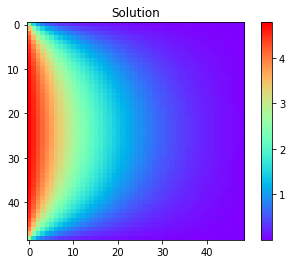

################################################################


In [6]:
#GPU
N=51
N_2 = N-2
h_sq = (2/(N-1))**2
dt=h_sq/4

#gpu implement
with Timer() as timer:
  u_t, t = time_iterate(N, dt)
print("GPU")
print("Calculated time t= ", t)
print("Correct Digits = ", get_correct_figures(t))
print("Explicit GPU implementation computation time (N={0}): {1}".format(N, timer.interval), "s")
    
#display solution
u_t_matrix = u_t.reshape((N_2,N_2))
fig = plt.figure()
plt.title('Solution')
im =plt.imshow(u_t_matrix, cmap = 'rainbow')
cb = fig.colorbar(im)
plt.show()

print("################################################################")



CPU
Calculated t=  0.423600000000008
Correct Digits =  2
Explicit CPU implementation iteration time (N=51): 0.043607473373413086 s


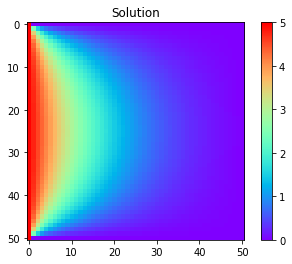

In [7]:
#CPU
N=51
h_sq = (2/(N-1))**2
dt=h_sq/4

with Timer() as timer:
  u_t,t = sparse_explicit_iterate(N, dt)
print("CPU")
print("Calculated t= ", t)
print("Correct Digits = ", get_correct_figures(t))
print("Explicit CPU implementation iteration time (N={0}): {1}".format(N, timer.interval), "s")

u_t_matrix = u_t.reshape((N,N))
fig = plt.figure()
plt.title('Solution')
im =plt.imshow(u_t_matrix, cmap = 'rainbow')
cb = fig.colorbar(im)

## Backward Euler - Implicit Time Stepping

The backward Euler method uses implicit time stepping, and can be defined by:
$$
\frac{U_{n+1} - U_n}{\Delta t} = f(U_{n+1}, t_{n+1}).
$$
This method is implicit since $U_{n+1}$ appears on both sides of the equation.

We can define the recurrence relation $U_{n+1} = (\boldsymbol{I}-\Delta t\boldsymbol{A})^{-1}U_n$, which can be rearranged to form a linear system of equations  $(\boldsymbol{I}-\Delta t\boldsymbol{A})U_{n+1} = U_n$ that we can solve using `scipy.sparse.linalg.spsolve`.

In [8]:
def implicit_iterate(N,dt):
  """Iterate over the backward Euler method for given N and dt"""
  its = np.int(1/dt)
  A = discretise_poisson(N)
  u = np.zeros((N,N), dtype =np.float32)
  
  x = u.reshape(N*N)
  u[:,0] = 5

  L = eye(N**2,N**2) - dt* A
  mid_point = np.int((N//2)*N + (N//2))

  t=0
  i=0
  for i in range(its):
    u_n = spsolve(L,x)
    temp_mid = u_n[mid_point]
    t+=dt 

    if temp_mid>1:
      break
    x=u_n
    #boundary condition
    x[::N] = 5
    i+=1
  return x, t

Calculated t=  0.42440000000000805
Correct Digits =  3
Implicit CPU implementation iteration time (N=51): 7.837576627731323 s


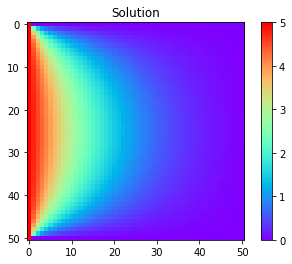

In [9]:
N=51
h_sq = (2/(N-1))**2
dt=h_sq/4

with Timer() as timer:
  u_t, t = implicit_iterate(N,dt)
print("Calculated t= ", t)
print("Correct Digits = ", get_correct_figures(t))
print("Implicit CPU implementation iteration time (N={0}): {1}".format(N, timer.interval), "s")

u_t_matrix = u_t.reshape((N,N))

fig = plt.figure()
plt.title('Solution')
im =plt.imshow(u_t_matrix, cmap = 'rainbow')
cb = fig.colorbar(im)


We can clearly see that for the same $N$ and $\Delta t$ as used for our forward Euler implementation, the time taken for our backwards Euler implementation is increased by two orders of magnitude, due to the need to solve a linear system of equations for each iteration. We do however acheieve a solution accurate to one more digit of the given value. 

##BENCHMARKING
We now aim to analyse the relationship between $N$, $\Delta t$, runtime, and the number of correct digits by performing our explicit and implicit methods for multiple $N$ and $\Delta t$ values.

In [10]:
 def bench_plot_getdata(N_start, N_end, dt_start, dt_end, fn):
  """Get benchmarking data for arrays of N, dt values and a given iterating function"""
  N_array = np.linspace(N_start,N_end, num = 6, endpoint = True, dtype='int')
  hsq_array = (2/(N_array-1))**2
  dt_array = np.linspace(dt_start,dt_end, num=6, endpoint =True)
  #dt_array = np.asarray([0.01,0.001,0.0001, 0.00001])

  N_data = []
  dt_data = []
  timer_data = []
  figs_data = []

  #gen data points
  for N in N_array:
    for dt in dt_array:
      with Timer() as timer:
        u_t, t = fn(N, dt)
      N_data.append(N)
      dt_data.append(dt)
      timer_data.append(timer.interval)
      figs_data.append(get_correct_figures(t))

  return N_array, N_data, dt_data, timer_data, figs_data

def bench_plot(N_array, N_data, dt_data, timer_data, figs_data):
  """plot benchmarking data"""
  fig = plt.figure(figsize=(8, 8))
  ax = fig.add_subplot(111, projection='3d')
  colors = ['r', 'k', 'y', 'g', 'm', 'b']

  ax.set_xticks(N_array)
  ax.set_xlabel('N')
  ax.set_ylabel('$\Delta t/ms$')
  ax.set_zlabel('Correct Digits')

  for N, c in zip(N_array, colors): #sub plots with given colour for each N value
    N_sub = []
    dt_sub = []
    timer_sub = []
    figs_sub = []
    sizes = []
    
    for n, i  in zip(N_data, range(len(N_data)+1)):
      if (n ==N):
        N_sub.append(n)
        dt_sub.append(dt_data[i]*1000)
        timer_sub.append(timer_data[i])
        figs_sub.append(figs_data[i])

      sizes = [t *100 for t in timer_sub] #size depends on runtime
    
      ax.scatter(N_sub, dt_sub, figs_sub, c=c, s=sizes)

  plt.show

Here we produce 3D plots visualising our results for the CPU implementations of the forward and backward Euler methods. In these plots, the size of each data point corresponds to the computation time taken to produce it, and each colour correspons to a value of $N$.

####**Explicit**
In the explicit plot, we see a significant region with zero correct digits. This corresponds to the dependance on the time step for a convergent solution that we see in the forward Euler method. When $\Delta t$ is above $\frac{h^2}{4}$ for a given $N$, we expect to see a divergent solution and zero correct digits, which is what we observe. 

We also see that the number of correct digits depends very much on the combination of $N$ and $\Delta t$. For example, for $\Delta t = 0.02ms$, we see that despite increasing $N$, we do not acheive any more correct digits, while the runtime increases considerably. This suggests that a great deal more computation time is required to acheieve only one further digit.

####**Implicit**
The implicit plot shows a similaer relationship between increasing $N$, decreasing $\Delta t$ and increasing runtime, though shows much less of a relationship between $N$ and the number of correct digits. Since the convergence of the backward Euler method does not depend on $\Delta t$, we observe that within the region of runtimes suitable for this notebook, the number of correct digits stongly on the timestep, and weakly on $N$.

Text(0.5, 0.92, 'Explicit Time Stepping')

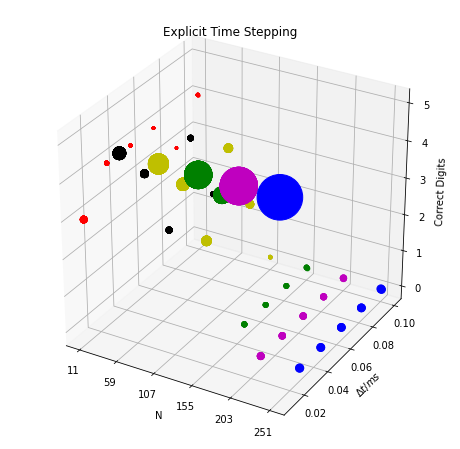

In [11]:
#EXPLICIT
N_array, N_data, dt_data, timer_data, figs_data = bench_plot_getdata(11, 251, 0.0001, 0.00001, sparse_explicit_iterate)
bench_plot(N_array, N_data, dt_data, timer_data, figs_data)
plt.title("Explicit Time Stepping")

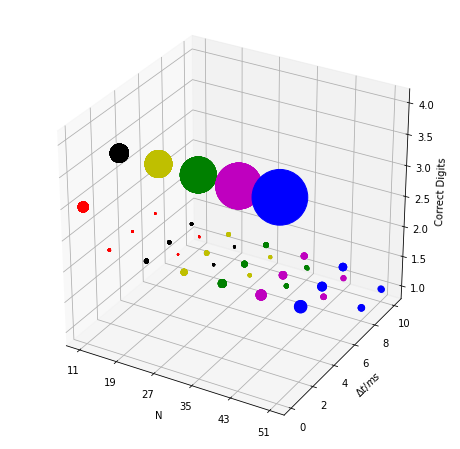

In [12]:
#IMPLICIT- takes about 1 minute
N_array, N_data, dt_data, timer_data, figs_data = bench_plot_getdata(11, 41, 0.01, 0.0001, implicit_iterate)
bench_plot(N_array, N_data, dt_data, timer_data, figs_data)

For interest, we now define a backwards Euler method that implements a conjugate gradient method to iteratively solve the linear systems of equations over each iteration of our recurrence relation. We find here that up to values on $N$ and $\Delta t$ that we can compute in a reasonable time, we see a decrease in runtime with no decrease in the number of correct digits we can acheive.

In [13]:
def implicit_iterative_iterate(N,dt):
  """Iterate over the backward Euler method for given N and dt, using the conjugate gradient method to solve
  our linear system of equations"""
  its = np.int(1/dt)
  A = discretise_poisson(N)
  u = np.zeros((N,N), dtype =np.float32)
  
  x = u.reshape(N*N)
  u[:,0] = 5

  L = eye(N**2,N**2) - dt* A
  mid_point = np.int((N//2)*N + (N//2))

  t=0
  i=0
  for i in range(its):

    u_n, _ = cg(L, x, tol=1E-8, maxiter=1000)
    temp_mid = u_n[mid_point]
    t+=dt 

    if temp_mid>1:
      break
    x=u_n
    #boundary condition
    x[::N] = 5
    i+=1
  return x, t

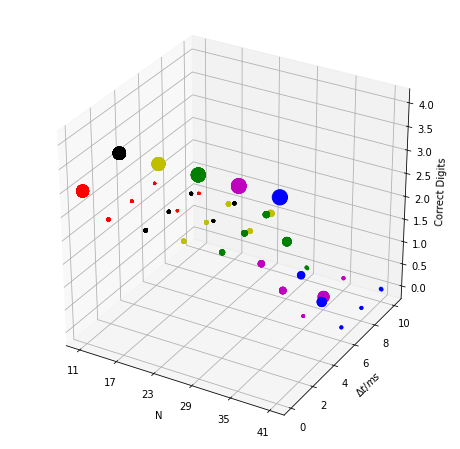

In [15]:
N_array, N_data, dt_data, timer_data, figs_data = bench_plot_getdata(11, 41, 0.01, 0.0001, implicit_iterative_iterate)
bench_plot(N_array, N_data, dt_data, timer_data, figs_data)